# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901) # ~50
    return corrected_lc

<IPython.core.display.Javascript object>


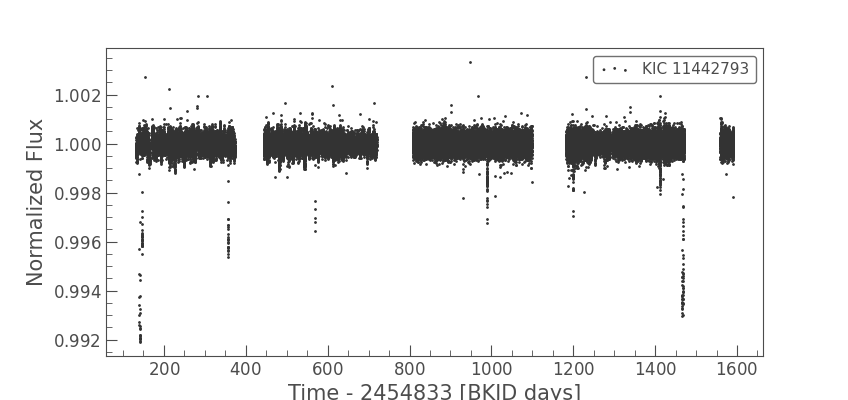

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min) # 
clc.scatter();

In [5]:
clc

time,flux,flux_err,time_bin_start,time_bin_size,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float64,float64,object,float64,int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
131.51764779216805,0.9995470694337373,0.00017638061739196304,131.5124394588347,900.0000000000016,0,0.0014456388307735324,471.76120035588144,486.65082751864014,1105,34751.5859375,6.121169567108154,1041.6097412109375,0.4687455892562866,39024.0625,6.886207580566406,0,471.73899627562633,0.00011278285091975704,486.6331789026923,0.00010532897431403399,471.76120035588144,0.00021950746304355562,486.65082751864014,0.0002825980191119015,-0.001997461775317788,0.043522827327251434
131.5280644588347,0.999803187691828,0.00017648968276144715,131.52285612550136,899.9999999999968,0,0.0014462423278018832,471.7616690361208,486.6508188283428,1106,34765.2734375,6.121645450592041,1039.3431396484375,0.4669772684574127,39034.0625,6.890465259552002,0,471.7393466779453,0.00011277536395937204,486.63340350841304,0.00010527230915613472,471.7616690361208,0.0002193584368797019,486.6508188283428,0.0002824289840646088,-0.0019289111951366067,0.04359747841954231
131.53848112550136,nan,nan,131.53327279216805,900.0000000000016,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
131.54889779216805,0.9996491114299791,0.00017649962160699186,131.5436894588347,900.0000000000016,8192,0.001446845824830234,471.76120453555575,486.65069644691107,1107,34759.65234375,6.121418476104736,1041.2794189453125,0.468036949634552,39028.046875,6.890853404998779,8192,471.73901698479347,0.00011274842108832672,486.6332715919184,0.00010529981955187395,471.76120453555575,0.00021939653379376978,486.65069644691107,0.00028248564922250807,-0.0020730169489979744,0.04369881749153137
131.5593144588347,nan,nan,131.55410612550136,899.9999999999968,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
131.56973112550136,0.9996544757872582,0.00017628042859024214,131.56452279216805,900.0000000000016,0,0.0014474493218585849,471.7606068055436,486.6504315228102,1108,34753.8203125,6.1212568283081055,1042.093994140625,0.4685816466808319,39028.2578125,6.882296085357666,0,471.7386558083762,0.00011271769471932203,486.6330262419891,0.00010534147440921515,471.7606068055436,0.00021942929015494883,486.6504315228102,0.00028248599846847355,-0.0022203188855201006,0.04331280663609505
131.58014779216805,nan,nan,131.5749394588347,900.0000000000016,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
131.5905644588347,0.9997458486729116,0.00017645934236179748,131.58535612550136,899.9999999999968,0,0.001448052586056292,471.7615353911509,486.64999447562116,1109,34762.87890625,6.121628761291504,1041.8536376953125,0.4677811563014984,39031.82421875,6.889280796051025,0,471.73928570112173,0.00011280620674369857,486.63267550260485,0.00010535077308304608,471.7615353911509,0.00021938281133770943,486.64999447562116,0.00028243291308172047,-0.0018438377883285284,0.04315270483493805


# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [6]:
period = np.linspace(50, 500, 45001)
bls = clc.to_periodogram(method='bls', period=period);

<IPython.core.display.Javascript object>


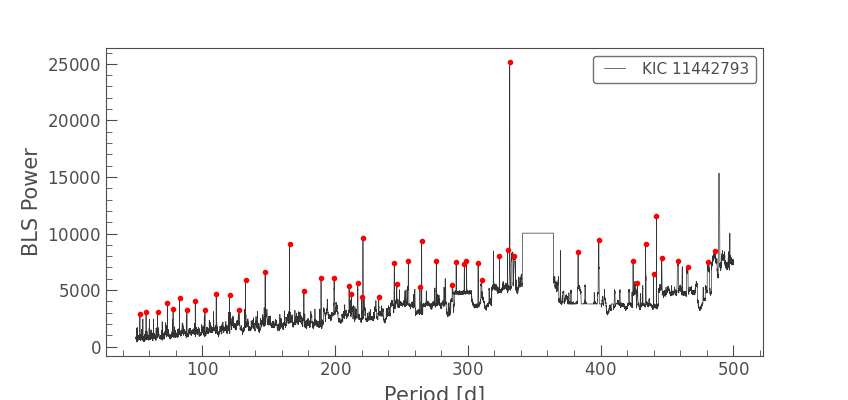

In [7]:
bls.plot();
peaks, _ = find_peaks(bls.power, distance=100, prominence=2000, threshold=1)
ind = np.where((bls.period[peaks].value%1.!=0)&(abs(bls.period[peaks].value-365)>5), True, False) # remove earth revolution
plt.plot(bls.period[peaks][ind], bls.power[peaks][ind], marker='.', ls='', c='r');

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [8]:
ind_sort_power = np.argsort(bls.power[peaks][ind])
for i in np.flip(ind_sort_power):
    print('Period=%.2f'%bls.period[peaks][ind][i].value+'day (Power=%.2f'%bls.power[peaks][ind][i]+')')

Period=331.57day (Power=25161.11)
Period=442.09day (Power=11530.90)
Period=221.04day (Power=9585.00)
Period=398.68day (Power=9466.34)
Period=265.26day (Power=9381.40)
Period=433.88day (Power=9092.92)
Period=165.78day (Power=9032.29)
Period=329.94day (Power=8532.55)
Period=485.85day (Power=8440.18)
Period=383.07day (Power=8346.62)
Period=335.04day (Power=8021.84)
Period=323.87day (Power=7980.60)
Period=446.07day (Power=7836.21)
Period=458.41day (Power=7613.28)
Period=299.02day (Power=7609.51)
Period=424.50day (Power=7599.89)
Period=255.23day (Power=7571.97)
Period=276.29day (Power=7529.43)
Period=291.19day (Power=7448.22)
Period=480.60day (Power=7443.80)
Period=244.67day (Power=7410.24)
Period=307.74day (Power=7352.05)
Period=297.39day (Power=7266.90)
Period=465.83day (Power=7077.57)
Period=147.36day (Power=6565.86)
Period=439.91day (Power=6382.00)
Period=199.33day (Power=6084.05)
Period=189.47day (Power=6062.23)
Period=132.63day (Power=5897.31)
Period=310.52day (Power=5850.04)
Period=2

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [9]:
ind_removal = np.array([], dtype='int')
for t in range(len(bls.period[peaks][ind])):
    ind_removal_tmp = np.where((abs(bls.period[peaks][ind][t].value/2.-bls.period[peaks][ind].value)<0.1)|\
                               (abs(bls.period[peaks][ind][t].value/3.-bls.period[peaks][ind].value)<0.1))[0]
    if len(ind_removal_tmp)>0:
        ind_removal = np.append(ind_removal, t)
    #print(bls.period[peaks][ind][t], ind_removal_tmp, bls.period[peaks][ind][ind_removal_tmp])

In [10]:
bls.period[peaks][ind][ind_removal]

<Quantity [132.63, 147.36, 165.78, 189.47, 221.04, 255.23, 265.26, 331.57,
           383.07, 398.68, 424.5 , 433.88, 439.91, 442.09, 465.83] d>

In [11]:
selected_period = np.array([])
for t in range(4):
    ind_range = np.where((bls.period[peaks][ind].value>100*t)&(bls.period[peaks][ind].value<100*(t+1)))[0]
    ind_range = np.array([element for element in ind_range if element not in ind_removal])
    #print(bls.period[peaks][ind][ind_range])
    #print(bls.power[peaks][ind][ind_range])
    ind_max = np.argmax(bls.power[peaks][ind][ind_range].value)
    selected_period = np.append(selected_period, bls.period[peaks][ind][ind_range][ind_max].value)
    print('Highest power in %d'%(100*t)+'-%d'%(100*(t+1))+'d : %.2f'%bls.period[peaks][ind][ind_range][ind_max].value\
         +'day (power=%.2f'%bls.power[peaks][ind][ind_range][ind_max].value+')')

Highest power in 0-100d : 82.89day (power=4313.45)
Highest power in 100-200d : 199.33day (power=6084.05)
Highest power in 200-300d : 299.02day (power=7609.51)
Highest power in 300-400d : 329.94day (power=8532.55)


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

Best period: 82.894day (power=4388.67)


<IPython.core.display.Javascript object>


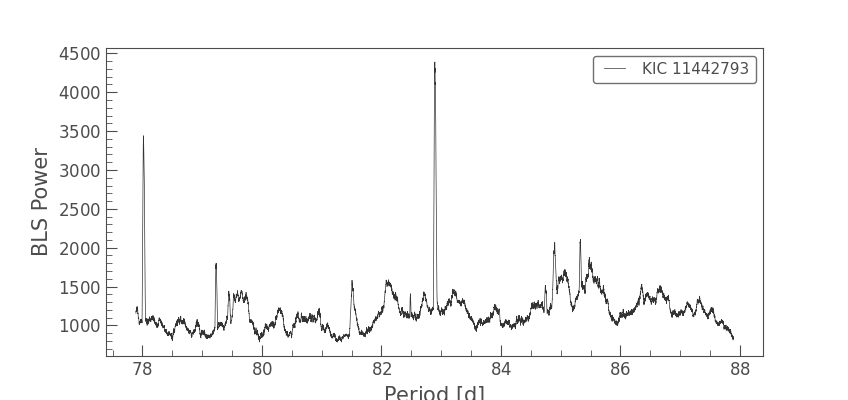

Best period: 199.322day (power=6184.50)


<IPython.core.display.Javascript object>


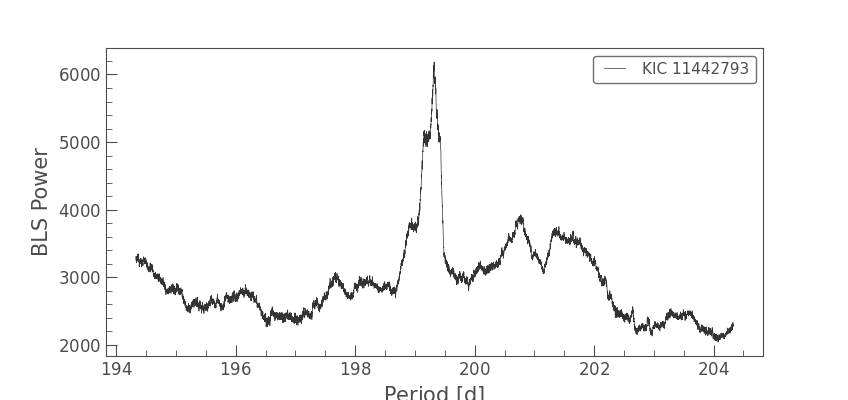

Best period: 299.023day (power=7633.84)


<IPython.core.display.Javascript object>


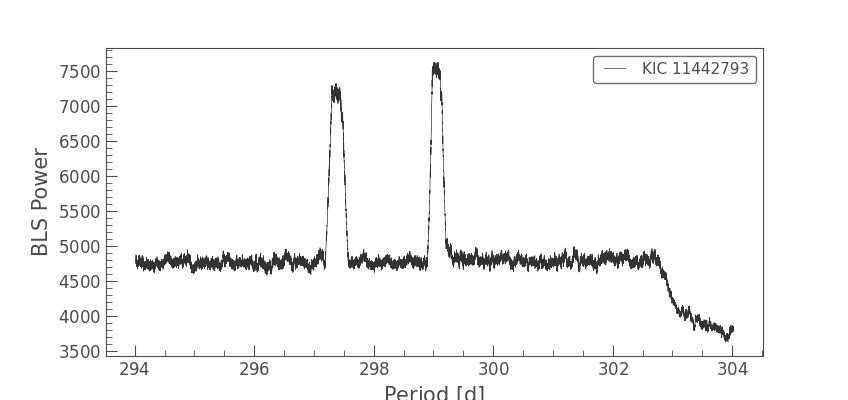

Best period: 331.570day (power=25161.11)


<IPython.core.display.Javascript object>


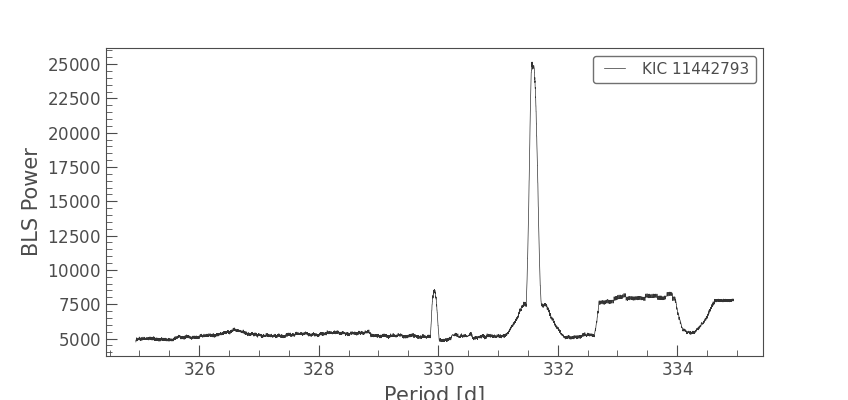

In [12]:
best_period = np.array([])
trainsit_time_arr = np.array([])
for i in range(4):
    rf_period = np.linspace(selected_period[i]-5, selected_period[i]+5, 10001)
    rf_bls = clc.to_periodogram(method='bls', period=rf_period, frequency_factor=500)
    print('Best period: %.3f'%rf_bls.period[np.argmax(rf_bls.power)].value\
          +'day (power=%.2f'%np.max(rf_bls.power)+')')
    rf_bls.plot();
    best_period = np.append(best_period, rf_bls.period[np.argmax(rf_bls.power)].value)
    trainsit_time_arr = np.append(trainsit_time_arr, rf_bls.transit_time[np.argmax(rf_bls.power)].value)

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

<IPython.core.display.Javascript object>


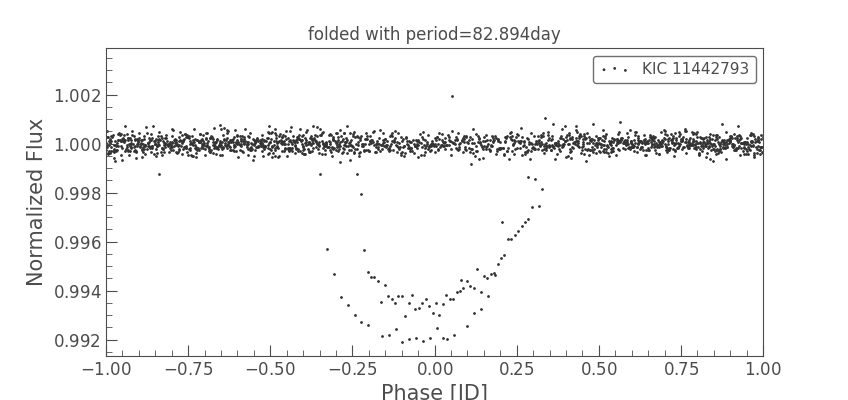

<IPython.core.display.Javascript object>


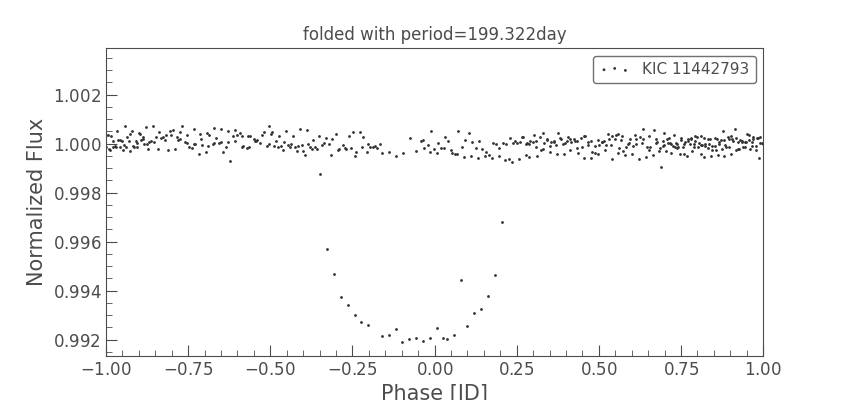

<IPython.core.display.Javascript object>


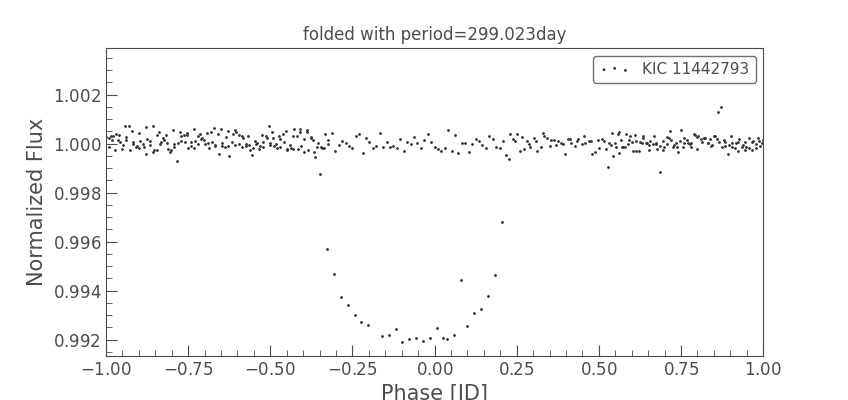

<IPython.core.display.Javascript object>


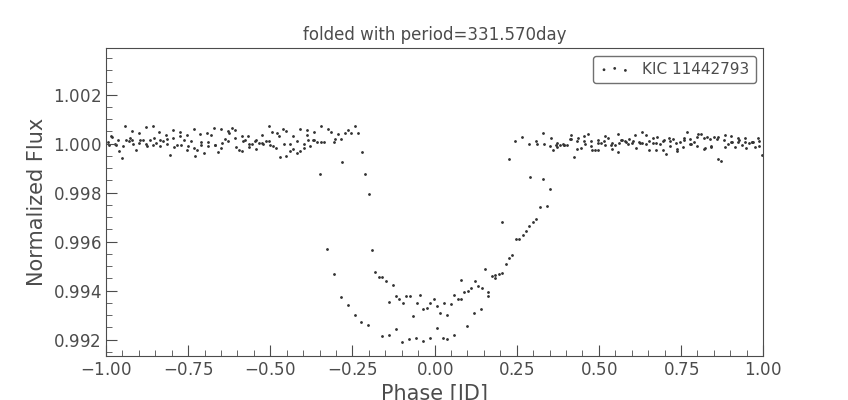

In [13]:
for i in range(4):
    ax = clc.fold(best_period[i], trainsit_time_arr[i]).scatter()
    ax.set_xlim(-1, 1)
    ax.set_title('folded with period=%.3f'%best_period[i]+'day')